Please install NumPyro by running:
`$ pip install --upgrade numpyro`

In [1]:
from functools import partial

# Regular Numpy
import numpy
import pandas as pd
import scipy.stats

from jax import lax, vmap
# JAX-wrapped Numpy
import jax.numpy as np
import jax.random as random

import numpyro
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS, SVI
from numpyro.optim import Adam
from numpyro.contrib.autoguide import AutoContinuousELBO, AutoDiagonalNormal

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Configure matplotlib format and default dimensions
%config InlineBackend.figure_formats = ['svg']
plt.rc("figure", figsize=(7,3.5))

# Perform inference using a CPU and 2 cores
numpyro.set_platform("cpu")
numpyro.set_host_device_count(2)

In [3]:
def generate_data(func, points, seed=0):
    """Generate a dataframe containing the covariate X, and observations Y
    """
    numpy.random.seed(seed)

    data = []
    for segment in points:
        x = numpy.linspace(*segment["xlim"], num=segment["n_points"])
        distribution = func(x)
        # Generate observations
        y = distribution.rvs()
        df = pd.DataFrame({"x": x, "y": y})
        data.append(df)

    return pd.concat(data, ignore_index=True)

In [4]:
def activation(x):
    """The non-linearity used in our neural network
    """
    return np.tanh(x)


def feedforward(X, Y, width=5, hidden=1, sigma=1.0, noise=1.0):
    """An implementation of feedforward Bayesian neural network with a fixed width of hidden layers
    and linear output node.
    """
    if Y is not None:
        assert Y.shape[1] == 1
    DX, DY, DH = X.shape[1], 1, width

    # Sample first layer
    i = 0
    w = numpyro.sample(f"w{i}", dist.Normal(np.zeros((DX, DH)), np.ones((DX, DH)) * sigma))
    b = numpyro.sample(f"b{i}", dist.Normal(np.zeros((DX, DH)), np.ones((DX, DH)) * sigma))
    z = activation(np.matmul(X, w) + b)  # N DH  <= first layer of activations

    for i in range(1, hidden):
        w = numpyro.sample(f"w{i}", dist.Normal(np.zeros((DH, DH)), np.ones((DH, DH)) * sigma))
        b = numpyro.sample(f"b{i}", dist.Normal(np.zeros((1, DH)), np.ones((1, DH)) * sigma))
        z = activation(np.matmul(z, w) + b)  # N DH  <= second layer of activations

    # Sample final layer of weights and neural network output
    i += 1
    w = numpyro.sample(f"w{i}", dist.Normal(np.zeros((DH, DY)), np.ones((DH, DY)) * sigma))
    b = numpyro.sample(f"b{i}", dist.Normal(0, sigma))
    z = np.matmul(z, w) + b  # N DY  <= output of the neural network

    # Likelihood
    numpyro.sample("Y", dist.Normal(z, noise), obs=Y)

In [5]:
def sample(
    model, num_samples, num_warmup, num_chains, seed=0, chain_method="parallel", summary=True, **kwargs
):
    """Run the No-U-Turn sampler
    """
    rng_key = random.PRNGKey(seed)
    kernel = NUTS(model)
    # Note: sampling more than one chain doesn't show a progress bar
    mcmc = MCMC(kernel, num_warmup, num_samples, num_chains, chain_method=chain_method)
    mcmc.run(rng_key, **kwargs)

    if summary:
        mcmc.print_summary()

    # Return a fitted MCMC object
    return mcmc

In [6]:
class ADVIResults:
    """A convenience class to work with the results of Variational Inference
    """

    def __init__(self, svi, guide, state, losses):
        self.svi = svi
        self.guide = guide
        self.state = state
        self.losses = losses

    def get_params(self):
        """Obtain the parameters of the variational distribution
        """
        return self.svi.get_params(self.state)

    def sample_posterior(self, rng_key, n_samples):
        """Sample from the posterior, making all necessary transformations of
        the reparametrized variational distribution.
        """
        params = self.get_params()
        posterior_samples = self.guide.sample_posterior(rng_key, params, sample_shape=(n_samples,))
        return posterior_samples

    def plot_loss(self):
        plt.plot(self.losses)
        plt.yscale("log")
        plt.xlabel("Iteration")
        plt.title(f"Negative ELBO by Iteration, Final Value {self.losses[-1]:.1f}")


def fit_advi(model, num_iter, learning_rate=0.01, seed=0):
    """Automatic Differentiation Variational Inference using a Normal variational distribution
    with a diagonal covariance matrix.
    """
    rng_key = random.PRNGKey(seed)
    adam = Adam(learning_rate)
    # Automatically create a variational distribution (aka "guide" in Pyro's terminology)
    guide = AutoDiagonalNormal(model)
    svi = SVI(model, guide, adam, AutoContinuousELBO())
    svi_state = svi.init(rng_key)

    # Run optimization
    last_state, losses = lax.scan(lambda state, i: svi.update(state), svi_state, np.zeros(num_iter))
    results = ADVIResults(svi=svi, guide=guide, state=last_state, losses=losses)
    return results

In [7]:
def predict(model, rng_key, samples, X):
    """Numpyro's helper function for prediction
    """
    model = handlers.substitute(handlers.seed(model, rng_key), samples)
    # note that Y will be sampled in the model because we pass Y=None here
    model_trace = handlers.trace(model).get_trace(X=X, Y=None)
    return model_trace["Y"]["value"]


def simulate_posterior_predictive(model, mcmc_or_vi, X_test, n_samples=None, seed=1, noiseless=False):
    """Predict Y_test at inputs X_test for a Numpyro model
    """
    # Set random state
    rng_key = random.PRNGKey(seed)

    # Obtain samples of the posterior
    if isinstance(mcmc_or_vi, MCMC):
        posterior_samples = mcmc.get_samples()
        n_samples = mcmc_or_vi.num_samples * mcmc_or_vi.num_chains
    elif isinstance(mcmc_or_vi, ADVIResults):
        assert n_samples is not None, "The argument `n_samples` must be specified for Variational Inference"
        posterior_samples = mcmc_or_vi.sample_posterior(rng_key, n_samples)
    else:
        raise ValueError("The `mcmc_or_vi` argument must be of type MCMC or ADVIResults")

    # Generate samples from the posterior predictive
    vmap_args = (posterior_samples, random.split(rng_key, n_samples))
    predictions = vmap(lambda samples, rng_key: predict(model, rng_key, samples, X_test))(*vmap_args)
    predictions = predictions[..., 0]

    # Optionally, return mean predictions (the variance of which is epistemic uncertainty)
    if noiseless:
        raise NotImplemented("A model with zero noise should be passed instead")

    return predictions

In [8]:
def plot_true_function(func, df, title=None):
    x = np.linspace(df.x.min(), df.x.max(), num=1000)
    distribution = func(x)
    lower, upper = distribution.interval(0.95)

    plt.fill_between(
        x, lower, upper, color="tab:orange", alpha=0.1, label="True 95% Interval",
    )
    plt.scatter(df.x, df.y, s=10, color="lightgrey", label="Observations")
    plt.plot(x, distribution.mean(), color="tab:orange", label="True Mean")
    if title is not None:
        plt.title(title)
    plt.legend(bbox_to_anchor=(1.04, 1), borderaxespad=0)
    
    
def plot_posterior_predictive(x, y, title=None, func=None, df=None):
    if func is not None and df is not None:
        plot_true_function(func, df)

    x = x.ravel()
    lower, upper = numpy.percentile(y, [2.5, 97.5], axis=0)
    plt.fill_between(x, lower, upper, color="tab:blue", alpha=0.1, label=f"Predicted 95% Interval")
    plt.plot(x, y.mean(axis=0), color="tab:blue", label=f"Predicted Mean")
    plt.title(title)
    plt.legend(bbox_to_anchor=(1.04, 1), borderaxespad=0)

# Accurate Uncertainties for Deep Learning Using Calibrated Regression

Analysis of the paper by Kuleshov et al. (2018)

Project team: Piotr Pekala, Benjamin Yuen, Dmitry Vukolov, Alp Kutlualp

### Outline

1. Problem statement: miscalibration and its sources
2. Related work
3. Proposed calibration algorithm
4. Experiments
5. Evaluation of the claims
6. Future work

# The Problem of Miscalibration

**Problem statement:** Proper quantification of uncertainty is crucial for applying statistical models to real-world situations. The Bayesian approach to modeling provides us with a principled way of obtaining such uncertainty estimates. Yet, due to various reasons, such estimates are often inaccurate. For example, a 95% posterior predictive interval does not contain the true outcome with 95% probability.

**Context:** <mark>why is this problem important or interesting? any examples?</mark>

# Sources of Miscalibration

Below we demonstrate that the problem of miscalibration exists and show why it exists for **Bayesian neural networks** in regression tasks. We focus on the following sources of miscalibration:
- The **prior** is wrong, e.g. too strong and overcertain
- The **likelihood function** is wrong. There is bias, i.e. the neural network is too simple and is unable to model the data.
- The **noise** specification in the likelihood is wrong.
- The **inference** is approximate or is performed incorrectly.

Our aim is to establish a causal link between each aspect of the model building process and a bad miscalibrated outcome.

# Methodology

1. **Data Generation:** We generate the data from a known true function with Gaussian noise. We then build multiple BNN models using:
  - different network architectures
  - several priors on the weights, depending on model complexity
  - different variance of the Gaussian noise in the likelihood function
  
2. **Inference**: We then obtain the posterior of the model by:
  - sampling from it with the No-U-Turn algorithm
  - approximating the posterior using Variational Inference with reparametrization and isotropic normals
  
3. **Diagnostics**: We check for convergence using trace plots, the effective sample size, and Gelman-Rubin tests. In the case of variational inference, we track the ELBO during optimization. The simulated posterior predictive is evaluated visually.

The probabilistic library [NumPyro](https://github.com/pyro-ppl/numpyro) provides fast implementations of both algorithms, which we make use of in this research. Due to time constraints we do not perform multiple random restarts, so the results may be subject to randomness.

# Example: a Toy Dataset

Using a simple data-generating function $y_i = 0.1 x^3_i + \varepsilon$, where $\varepsilon \sim \mathcal{N}(0, 0.5^2)$ and a series of BNN models we evaluate the impact of our design choices on the posterior predictive.

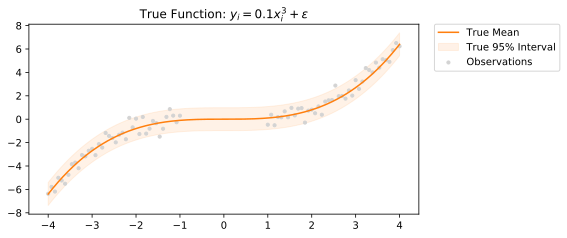

In [9]:
# Define the true function and generate observations
func = lambda x: scipy.stats.norm(loc=0.1 * x ** 3, scale=0.5)
func.latex = r"$y_i = 0.1x_i^3 + \varepsilon$"

data_points = [
    {"n_points": 40, "xlim": [-4, -1]},
    {"n_points": 40, "xlim": [1, 4]},
]
df = generate_data(func, points=data_points, seed=4)

# Plot the data
plot_true_function(func, df, title=f"True Function: {func.latex}")

# Proper Posterior Predictive

A neural network with 10 nodes in a single hidden layer, well-chosen prior and noise, as well as correctly performed inference using sampling result in a posterior predictive that adequately reflects both epistemic and aleatoric uncertainty:

In [10]:
# Observations
X = df[["x"]].values
Y = df[["y"]].values
X_test = numpy.linspace(X.min(), X.max(), num=1000)[:, np.newaxis]

# Number of hidden layers
hidden = 1
# Width of hidden layers
width = 10
# Standard deviation of the prior
sigma = 2.0
# Standard deviation of the likelihood
noise = 0.5

# Instantiate the model with prior standard deviation and likelihood noise
model = partial(feedforward, X=X, Y=Y, width=width, hidden=hidden, sigma=sigma, noise=noise)

In [11]:
%%time
# NUTS parameters
num_chains = 2
num_samples = 2000
num_warmup = 2000

# Run the No-U-Turn sampler. Note: sampling more than one chain in parallel doesn't show a progress bar
mcmc = sample(model, num_samples, num_warmup, num_chains, seed=0, summary=True)


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   b0[0,0]      0.07      2.30      0.06     -3.53      3.81    785.15      1.00
   b0[0,1]     -0.05      2.27     -0.02     -3.62      3.66    682.22      1.00
   b0[0,2]      0.01      2.26     -0.02     -3.62      3.67    700.38      1.00
   b0[0,3]      0.06      2.25      0.08     -3.54      3.70    702.30      1.00
   b0[0,4]      0.03      2.30      0.05     -3.59      3.83    772.64      1.00
   b0[0,5]      0.02      2.28      0.06     -3.69      3.70    772.97      1.00
   b0[0,6]     -0.07      2.22     -0.10     -3.71      3.49    708.42      1.00
   b0[0,7]      0.02      2.29      0.08     -3.54      3.78    675.84      1.01
   b0[0,8]     -0.13      2.25     -0.11     -3.77      3.56    729.95      1.01
   b0[0,9]     -0.16      2.23     -0.13     -3.76      3.44    728.31      1.01
        b1     -0.01      1.45     -0.02     -2.51      2.23   2788.87      1.00
   w0[0,0]     -0.12      1

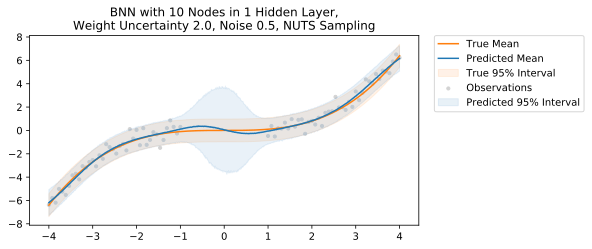

In [12]:
# Generate the posterior predictive and plot the results
posterior_predictive = simulate_posterior_predictive(model, mcmc, X_test, seed=1)
plot_posterior_predictive(
    X_test,
    posterior_predictive,
    func=func,
    df=df,
    title=f"BNN with {width} Nodes in {hidden} Hidden Layer,\n"
    f"Weight Uncertainty {sigma}, Noise {noise}, NUTS Sampling",
)

Naturally, our claims regarding the adequacy of epistemic uncertainty are subjective due to absence of universal quantitative metrics.